# NE 630 - Lesson 23

**LAST TIME**: reactivity control and fission products (our focus was on Xe-135, but Sm-149 is also important!)

**TODAY**: fuel depletion, burnup, and the impact on reactivity 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

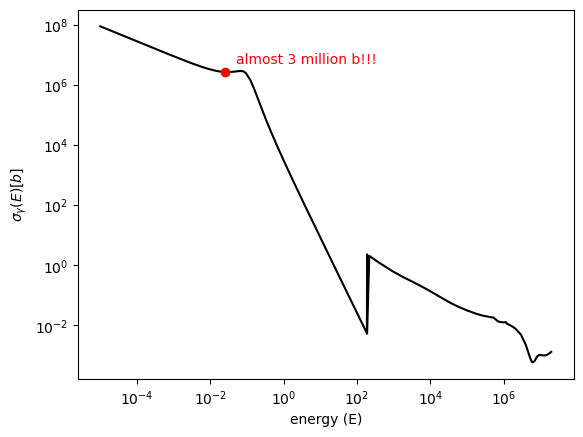

In [2]:
E, sig_Xe135 = np.loadtxt("Xe135g.txt", unpack=True, delimiter=",", skiprows=1)
plt.loglog(E, sig_Xe135,'k')
plt.plot(0.0253, 2668930.0, 'ro')
plt.text(0.05,  5e6, "almost 3 million b!!!", color="r")
plt.xlabel('energy (E)')
plt.ylabel('$\sigma_{\gamma}(E) [b]$');

**...back to computational example!**

In [4]:
from scipy.integrate import odeint

In [5]:
λ_Xe = np.log(2)/(9.2*3600)
λ_I = np.log(2)/(6.7*3600)
γ_Xe = 0.00258
γ_I = 0.0629
φ = 2e14
Σ_f = 0.16
σ_Xe = 2.6e6*1e-24

In [7]:
N_oo = (γ_Xe+γ_I)*Σ_f*φ / (λ_Xe + σ_Xe*φ)
N_oo / 1e15

3.8736368194940605

In [8]:
N_oo * σ_Xe

0.010071455730684556

$$
\begin{split}
  \frac{d N_I}{dt} &= -\lambda_I N_I(t) + \gamma_I \Sigma_f \phi \\
    \frac{d N_{Xe}}{dt} &= -\lambda_{Xe} N_{Xe}(t) -  \sigma^{Xe}_a N_{Xe}(t) \phi + \lambda_I N_I(t) + \gamma_{Xe} \Sigma_f \phi
\end{split}
$$

or $\frac{d\mathbf{N}}{dt} = \mathbf{f}(\mathbf{N}(t), t)$.

In [12]:
def rhs(N, t):
    φ =  2e14
    if t > 2*24*3600:
        φ = 0
    N_I, N_Xe = N
    dN_Idt = -λ_I*N_I +  γ_I*Σ_f*φ
    dN_Xedt = -λ_Xe*N_Xe - σ_Xe*φ*N_Xe + λ_I*N_I + γ_Xe*Σ_f*φ 
    return (dN_Idt, dN_Xedt)

In [13]:
ic = (0.0, 0.0)
times = np.linspace(0, 4*24*3600., 1000)
N = odeint(rhs, y0=ic, t=times)
N_I = N[:, 0]
N_Xe = N[:, 1]

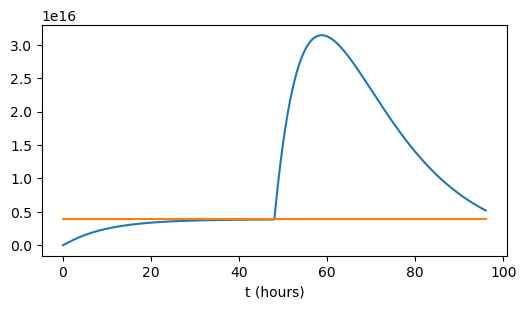

In [14]:
plt.figure(figsize=(6, 3))
plt.plot(times/(3600.), N_Xe)
plt.plot(times/(3600.), np.ones(len(times))*N_oo)
plt.xlabel("t (hours)");

# What *is* Depletion?

**Depletion** refers to the changes--primarily decreases--in the number of *fuel nuclei* in the core as a function of time at power.  

Here's a typical *actinide chain* used for real-world reactor analysis that accounts for 25 nuclides:

![Actinide chain](https://www-nds.iaea.org/wimsd/images/achain.gif)

(Source: https://www-nds.iaea.org/wimsd/achain.htm)

Click [here](https://www-nds.iaea.org/wimsd/fpbchains.htm) for chains to track various fission products.

# A Simplified Depletion Model

**First approximation**: Track only ${}^{235}$U, ${}^{238}$U, and ${}^{239}$Pu, and ignore their decay.

**Second approximation**: ${}^{239}$Pu is produced *directly* and *immediately* from ${}^{238}$U (n,$\gamma$) reactions.

**Third approximation**: The amount of ${}^{238}$U is so large that absorption losses are neglible, and the amount of ${}^{238}$U remains constant.

**The resulting model**:

$$
\begin{split}
\frac{dN^{\text{U}235}}{dt} &=  -N^{\text{U}235}(t) \bar{\sigma}^{\text{U}235}_a \phi \\
 \longrightarrow \, & \boxed{N^{\text{U}235}(t) = N^{\text{U}235}(0) e^{-\bar{\sigma}^{\text{U}235}_a \phi t}} 
\end{split}
\tag{10.27 $\rightarrow$ 10.31}
$$

$$
\begin{split}
\frac{dN^{\text{U}238}}{dt} &= -N^{\text{U}238}(t) \bar{\sigma}^{\text{U}238}_a \phi \approx 0 \\
 \longrightarrow \, & \boxed{N^{\text{U}238}(t) = N^{\text{U}238}(0)}
\end{split}
\tag{10.27 $\rightarrow$  10.34}
$$

$$
\begin{split}
\frac{dN^{\text{Pu}239}}{dt} &=  
 N^{\text{U}238}(t) \bar{\sigma}^{\text{U}238}_{\gamma} \phi 
 - N^{\text{Pu}239}(t) \bar{\sigma}^{\text{Pu}239}_a \phi \\
\longrightarrow \, & \boxed{N^{\text{Pu}239}(t) 
  = \frac{\bar{\sigma}^{\text{U}238}_{\gamma}}{\bar{\sigma}^{\text{Pu}239}_a} 
    N^{\text{U}238}(0) \left [1 - e^{-\bar{\sigma}^{\text{Pu}239}_a \phi t} \right ]}
\end{split}    
\tag{10.30 $\rightarrow$  10.37}
$$

## Example

Consider 4% enriched UO$_2$ fuel.  Compute the number densities of ${}^{239}$Pu and ${}^{235}$U as functions of time assuming $\phi = 10^{14}$ [1/cm$^2$-s] and the following cross sections:

|              | $\bar{\sigma}_a$ [b] | $\bar{\sigma}_f$ [b] |
|--------------|------------------|------------------|
| U-235  | 57.20388         | 46.88856         | 
| U-238  | 1.02191          | 0.10507         | 
| Pu-239 | 195.10020        | 124.41051         | 

These cross sections are averaged over the *entire* flux spectrum.

Plot the number densities of ${}^{239}$Pu and ${}^{235}$U over 1 year of operation.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
ϕ = 2e14
σ235a = 57.20388;  σ235f = 46.88856
σ238a = 1.02191 ;   σ238f = 0.10507 
σ239a = 195.10020;  σ239f = 124.41051 

In [17]:
N_a = 6.022e23
ρUO2 = 10
N_238_0 = 0.96*(238/(238+2*16))*ρUO2*N_a/238
N_235_0 = 0.04*(238/(238+2*16))*ρUO2*N_a/235

In [18]:
N_235 = lambda t: N_235_0 * np.exp(-σ235a*1e-24*ϕ*t)

In [19]:
σ238g = σ238a - σ238f

In [20]:
N_239 = lambda t: (σ238g/σ239a)*N_238_0*(1 - np.exp(-σ239a*1e-24*ϕ*t))

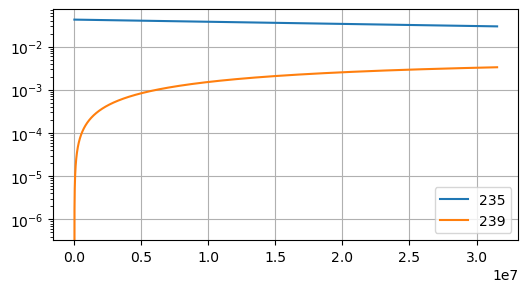

In [21]:
times = np.linspace(0, 365*24*3600, 10000)
plt.figure(figsize=(6,3))
plt.semilogy(times, N_235(times)/N_238_0, label='235')
plt.semilogy(times, N_239(times)/N_238_0, label='239')
plt.grid(True)
plt.legend();

# Time, Fluence, and Burnup

Time is a familiar quantity, but alternatives can be useful when quantifying depletion effects.

**Fluence** is the time-integrated flux, or

$$
   \Phi(t) = \int^t_0 \phi(t')dt' 
$$

and has units of [1/cm$^2$].

**Burnup** is the energy produced per (initial) unit mass of actinides.

Possible units:

  - MWd/kg  (most common)
  - GWd/MTU (equivalent to MWd/kg; MTU is "metric ton (of) uranium")
  - J/kg

# Reactivity and Depletion

The net impact of depletion of reactivity is most often a reduction. 

The multiplication factor can now be written as

$$
  k(t) = \frac{\big(\nu\bar{\sigma}^{\text{U}235}_{fT} N^{\text{U}235}(t) + \nu\bar{\sigma}^{\text{Pu}239}_{fT} N^{\text{Pu}239}(t)\big)\varepsilon p P_{NL}}
  {\bar{\sigma}^{\text{U}235}_{aT} N^{\text{U}235}(t) + \bar{\sigma}^{\text{Pu}239}_{aT} N^{\text{Pu}239}(t) + \Sigma_{aT}^{\text{U}238} + \varsigma (V_m \big / V_f)\Sigma_{aT}^m}
  \tag{10.39}
$$

**Note the T subscripts on the cross sections!**  When doing depletion, we use the total flux over the entire energy range and must use the appropriate 1-group cross sections.  When using the four-factor formula, we need the appropriate two-group cross sections!  (The first paragraph on page 244 of the book points out that the T subscript is dropped; I'm replacing it here for clarity!)

## Example

Consider the depletion we did above.  The appropriate *thermal* cross sections for the fuel nuclides are

|              | $\bar{\sigma}_a$ [b] | $\bar{\sigma}_f$ [b] |
|--------------|------------------|------------------|
| U-235  | 297.40444         | 253.08847         | 
| U-238  | 1.32087           | 0.00000        | 
| Pu-239 | 1146.51259        | 732.21983       | 

Assuming $\nu = 2.5$, $\varsigma = 1.1$, $V_m/V_f = 1$, $p=0.6$, $\varepsilon=1.3$, $P_{NL}=0.95$, and $\Sigma^m_{aT} = 0.007$ [1/cm], plot the *reactivity* versus *fluence* over the same time period.

In [22]:
σ235aT = 297.40444 ;  σ235fT =  253.08847 
σ238aT = 1.32087   ;  σ238fT =  0.00000 
σ239aT = 1146.51259;  σ239fT =  732.21983 

In [23]:
ς = 1.1; p=0.6; Ɛ = 1.3; P_NL = 0.95; ν=2.5; ΣaT = 0.007

In [24]:
def k(t):
    return ((ν*σ235fT*N_235(t) + ν*σ239fT*N_239(t))*Ɛ*p*P_NL) /       \
    (σ235aT*N_235(t) + σ239aT*N_239(t) + σ238aT*N_238_0 + ς*ΣaT)

def rho(t):
    return (k(t)-1)/k(t)

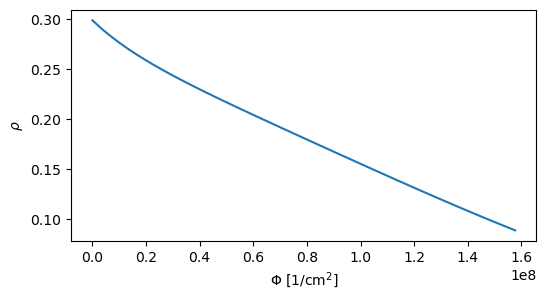

In [26]:
times = np.linspace(0, 5*365*24*3600)
fluence = ϕ*times
plt.figure(figsize=(6,3))
plt.plot(times, rho(times))
plt.ylabel(r'$\rho$')
plt.xlabel('$\Phi$ [1/cm$^2$]');

**Food for thought**: If the reactivity is declining, and our fissile nuclides are declining, what happens to the *fission rate* in time?